Opening the Data Sources

In [12]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import scipy as stats
import scipy
import seaborn as sns
import zipfile
import sqlite3
import math

In [13]:
movie_gross_data = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
print(movie_gross_data)

                                            title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Actor Prepares       Grav.          1700.0   

     foreign_gross  year  


In [14]:
#Finding missing values
movie_gross_data.isnull().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [15]:
#tmdb_movie_data = pd.read_csv("zippedData/tmdb.movies.csv.gz")
movie_budgets_data = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
movie_info_data = pd.read_csv("zippedData/rt.movie_info.tsv.gz",sep="\t")

In [5]:
#movie_reviews_data = pd.read_csv("zippedData/rt.reviews.tsv.gz",sep="\t")

In [16]:
#tmdb_movie_data.isnull().sum()
#movie_budgets_data.isnull().sum()
#print(movie_budgets_data)
#missing a lot of values
movie_info_data.isnull().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

In [17]:
def dejar_solo_cifras(txt):
  return "".join(c for c in txt if c.isdigit())
w_gross = movie_budgets_data['worldwide_gross'].map(dejar_solo_cifras)
p_budget = movie_budgets_data['production_budget'].map(dejar_solo_cifras)
movie_budgets_data['w_gross'] = w_gross.astype(float)
movie_budgets_data['p_budget'] = p_budget.astype(float)
movie_budgets_data = movie_budgets_data.assign(gain = movie_budgets_data['w_gross']*100/ movie_budgets_data['p_budget'])
movie_budgets_data


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,w_gross,p_budget,gain
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2.776345e+09,425000000.0,653.257713
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",1.045664e+09,410600000.0,254.667286
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",1.497624e+08,350000000.0,42.789243
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",1.403014e+09,330600000.0,424.384139
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",1.316722e+09,317000000.0,415.369636
...,...,...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,0.000000e+00,7000.0,0.000000
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495",2.404950e+05,6000.0,4008.250000
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",1.338000e+03,5000.0,26.760000
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,0.000000e+00,1400.0,0.000000


In [18]:
#stadistics plotting gains 
mean_gain = movie_budgets_data['gain'].mean()
max_gain = movie_budgets_data['gain'].max()
desv =  movie_budgets_data['gain'].std()
print('The average of gains is:'+ str(mean_gain))
print('The maximum of gains is:'+ str(max_gain))

The average of gains is:480.01613657949645
The maximum of gains is:180000.0


In [19]:
#stadistics relating gains vs studio or genre
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [20]:
plt.style.use('ggplot')

<AxesSubplot:title={'center':'Revenue per movie'}, xlabel='Movies', ylabel='Revenue percentage'>

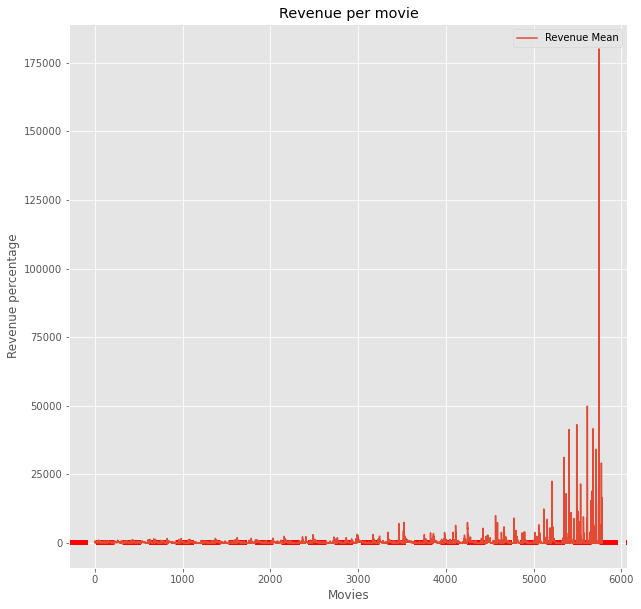

In [21]:
plt.xlabel("Movies")
plt.ylabel("Revenue percentage")
plt.title("Revenue per movie")
plt.axhline(y=mean_gain, color="red", linewidth=5, linestyle="--")
plt.legend(
    labels=["Revenue Mean"],
    fontsize="large"
);
movie_budgets_data['gain'].plot()

In [12]:
#delete quartiles for plot

In [22]:
merged_gross_budget = pd.merge(movie_gross_data, movie_budgets_data, how = "inner", left_on= "title", right_on= "movie")
data_for_analysis = merged_gross_budget[["title",'studio','gain']]
studio_gain = data_for_analysis.groupby(['studio']).mean()
s_mean = studio_gain['gain'].mean()
s_max = studio_gain.max()
studio_gain

,gain
studio,
3D,330.304060
A24,424.242218
ALP,11.245996
ATO,18.177488
Affirm,403.844830
...,...
WB,324.805506
WB (NL),1749.593358
WHE,5.470657


<AxesSubplot:title={'center':'Average Revenue per studio'}, xlabel='studio', ylabel='Revenue percentage'>

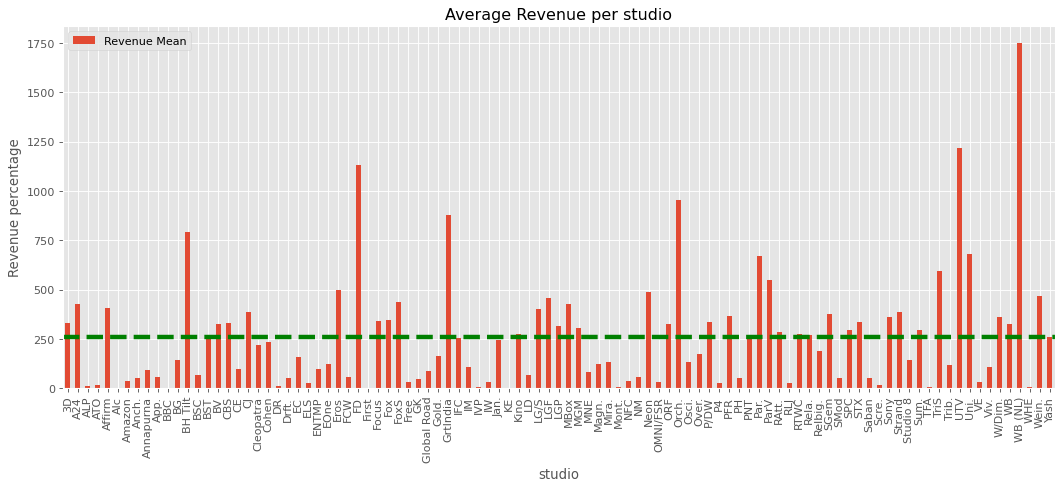

In [26]:
#studio_gain.plot.bar( rot=90)
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel("Studio")
plt.ylabel("Revenue percentage")
plt.title("Average Revenue per studio")
plt.axhline(y=s_mean, color="green", linewidth=4, linestyle="--")
plt.legend(
    labels=["Revenue Mean"],
    fontsize="large"
);
studio_gain['gain'].plot.bar()

In [14]:
#maximum average studio gain
studio_gain[studio_gain['gain']==studio_gain['gain'].max()]

,gain
studio,
WB (NL),1749.593358


In [16]:
#Select only values above the average
def highest_avrg(data):
    filtered_data = []
    for x in studio_gain['gain'] :
        if x > s_mean :
            print(x)
    return filtered_data
highest_avrg(studio_gain)

330.30406
424.24221765949966
403.84483
789.6510023333334
260.50686334217505
324.51158974880445
331.97386828923345
387.3742677165354
499.188647070217
1131.6942725698414
341.0431276785584
345.2702125097201
436.45183052575993
878.3430466666666
272.1096
400.6210045374062
454.80756775577686
316.4258
427.1846735042735
305.213397
489.0673545454545
327.431114191873
953.82132
335.6840939838644
366.3756185618729
671.6738320793722
548.3369998765431
284.56374440487
274.67048174019607
267.27163352947736
373.650084431363
295.2459575324502
333.04132856439276
362.59947999272606
387.28492
292.6530461682057
591.7257605352255
1217.1985264912282
678.39072956556
358.5364323193242
324.8055059917188
1749.5933584667123
468.0994107006328


[]

<AxesSubplot:title={'center':'Highest Revenue per studio'}, xlabel='studio', ylabel='Revenue percentage'>

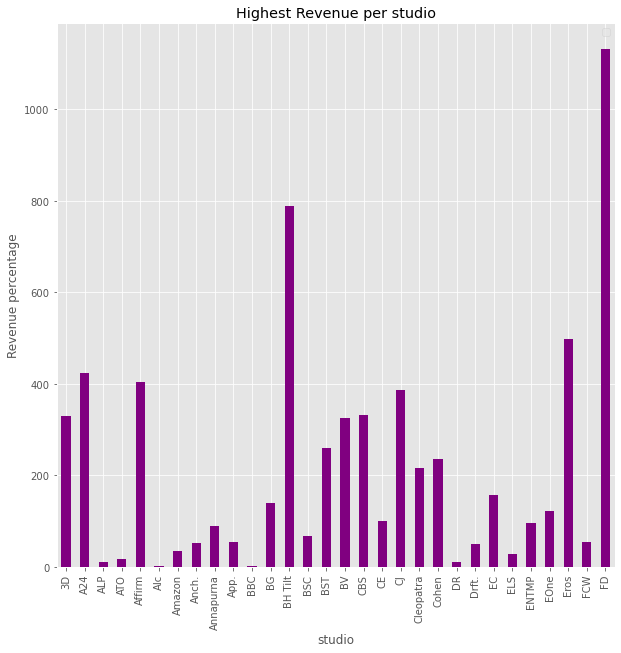

In [28]:
top_30 = studio_gain.iloc[:30]
plt.xlabel("Studio")
plt.ylabel("Revenue percentage")
plt.title("Highest Revenue per studio")
plt.legend(
    labels=["Revenue Mean"],
    fontsize="large"
);
top_30['gain'].plot.bar(color='purple')

In [5]:
with zipfile.ZipFile("zippedData/im.db.zip", "r") as zObject:
        zObject.extractall()

In [6]:
conn = sqlite3.connect("im.db")
cur = conn.cursor()

In [7]:
q= pd.read_sql("""
SELECT averagerating as avg_rating, person_id
FROM movie_ratings
JOIN directors
    USING (movie_id)
WHERE averagerating >= 8.5
ORDER BY avg_rating DESC 
;
""", conn)
q

,avg_rating,person_id
0,10.0,nm4637768
1,10.0,nm5472684
2,10.0,nm3704168
3,10.0,nm4166962
4,10.0,nm0880350
...,...,...
7656,8.5,nm9864413
7657,8.5,nm9864413
7658,8.5,nm9864413
7659,8.5,nm9864413


In [9]:
d= pd.read_sql("""
SELECT person_id, primary_name
FROM persons 
;
""", conn)
d

,person_id,primary_name
0,nm0061671,Mary Ellen Bauder
1,nm0061865,Joseph Bauer
2,nm0062070,Bruce Baum
3,nm0062195,Axel Baumann
4,nm0062798,Pete Baxter
...,...,...
606643,nm9990381,Susan Grobes
606644,nm9990690,Joo Yeon So
606645,nm9991320,Madeline Smith
606646,nm9991786,Michelle Modigliani


In [67]:
#Merging rating with directors
directors_rating = q.merge (d, on="person_id", how="left")
data_for_analysis_by_rating = directors_rating.groupby(by="primary_name", as_index=False).mean()
top_10_by_rating = data_for_analysis_by_rating.iloc[:10]
top_rated = top_10_by_rating.set_index('primary_name')
top_rated

,avg_rating
primary_name,
A. Haluk Unal,8.8
A.J. Ali,9.0
A.K.S. Nambiar,9.3
Aaron Biebert,8.9
Aaron Huggett,9.1
Aaron Jackson,9.2
Aaron Jay Rome,9.0
Aaron K. Carter,8.6
Aaron Lieber,9.0


<AxesSubplot:title={'center':'Best rated directors'}, xlabel='primary_name', ylabel='Average rating'>

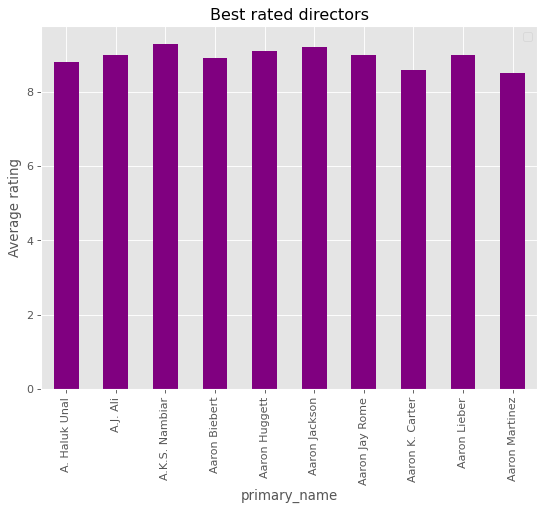

In [71]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Directors')
plt.ylabel('Average rating')
plt.title("Best rated directors")
plt.legend(
    labels=["Revenue Mean"],
    fontsize="large"
); 
top_rated['avg_rating'].plot.bar(rot= 90, color='purple')

In [ ]:
df = pd.read_sql("""SELECT * FROM movie_ratings, movie_basics ;""", conn)
df

In [ ]:
df.isnull().sum()